## India Plastic Waste Trade

##### Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train['index'] = 0
test['index'] = 1

y = train['Trade Value']
train = train.drop(['Trade Value'], axis=1)

Skipping exploratory data analysis as this was already completed in Tableau.

In [3]:
total = pd.concat([train, test])
total = total.drop(['Continent'], axis=1)

In [4]:
total = pd.get_dummies(total)

In [5]:
X = total[total['index'] == 0]
final = total[total['index'] == 1]

X = X.drop('index', axis = 1)
final = final.drop('index', axis = 1)

##### Modeling

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [7]:
#splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#scaling
scaler = StandardScaler().fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=list(X_train.columns))
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=list(X_test.columns))

#scaling whole set with X_train yields better results
final = pd.DataFrame(scaler.transform(final), columns=list(final.columns))
X = pd.DataFrame(scaler.transform(X), columns=list(X.columns))

In [8]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from bayes_opt import BayesianOptimization
from sklearn.linear_model import LogisticRegression


C:\Users\tozhy\AppData\Roaming\Python\Python39\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [15]:
#list of regressors created
regressors= {
    "XGBRegressor": XGBRegressor(),
    "LGBMRegressor": LGBMRegressor(),
    "RandomForestRegressor": RandomForestRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "GaussianProcessRegressor": GaussianProcessRegressor(),
    "SVR": SVR(),
    "Ridge":Ridge(),
    "BayesianRidge": BayesianRidge(),
    "ElasticNet": ElasticNet(),
}

df_models = pd.DataFrame(columns=['model', 'rmse'])

#rank regressors by rmse
for i in regressors:

    reg = regressors[i]
    model = reg.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    row = {'model': i,
           'rmse': np.sqrt(mean_squared_error(y_test, y_pred))
    }

    df_models = df_models.append(row, ignore_index=True)
    
df_models.sort_values(by='rmse', ascending=True)

C:\Users\tozhy\AppData\Roaming\Python\Python39\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\tozhy\AppData\Local\Temp\ipykernel_15584\4154963562.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)
C:\Users\tozhy\AppData\Local\Temp\ipykernel_15584\4154963562.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)
C:\Users\tozhy\AppData\Local\Temp\ipykernel_15584\4154963562.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mod

,model,rmse
0,XGBRegressor,813640.720237
2,RandomForestRegressor,890022.428314
3,DecisionTreeRegressor,1156355.777855
1,LGBMRegressor,1711547.629394
6,Ridge,3681420.430772
8,ElasticNet,3852425.672193
7,BayesianRidge,4530570.835415
5,SVR,4623650.301496
4,GaussianProcessRegressor,76260691.458612


XGBRegressor has lowest error criterion.

Selected as model.

In [9]:
model = XGBRegressor(random_state=1)

In [10]:
y_pred = model.fit(X_train_scaled, y_train).predict(X_test_scaled)

C:\Users\tozhy\AppData\Roaming\Python\Python39\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


C:\Users\tozhy\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0, 'Sample Number')

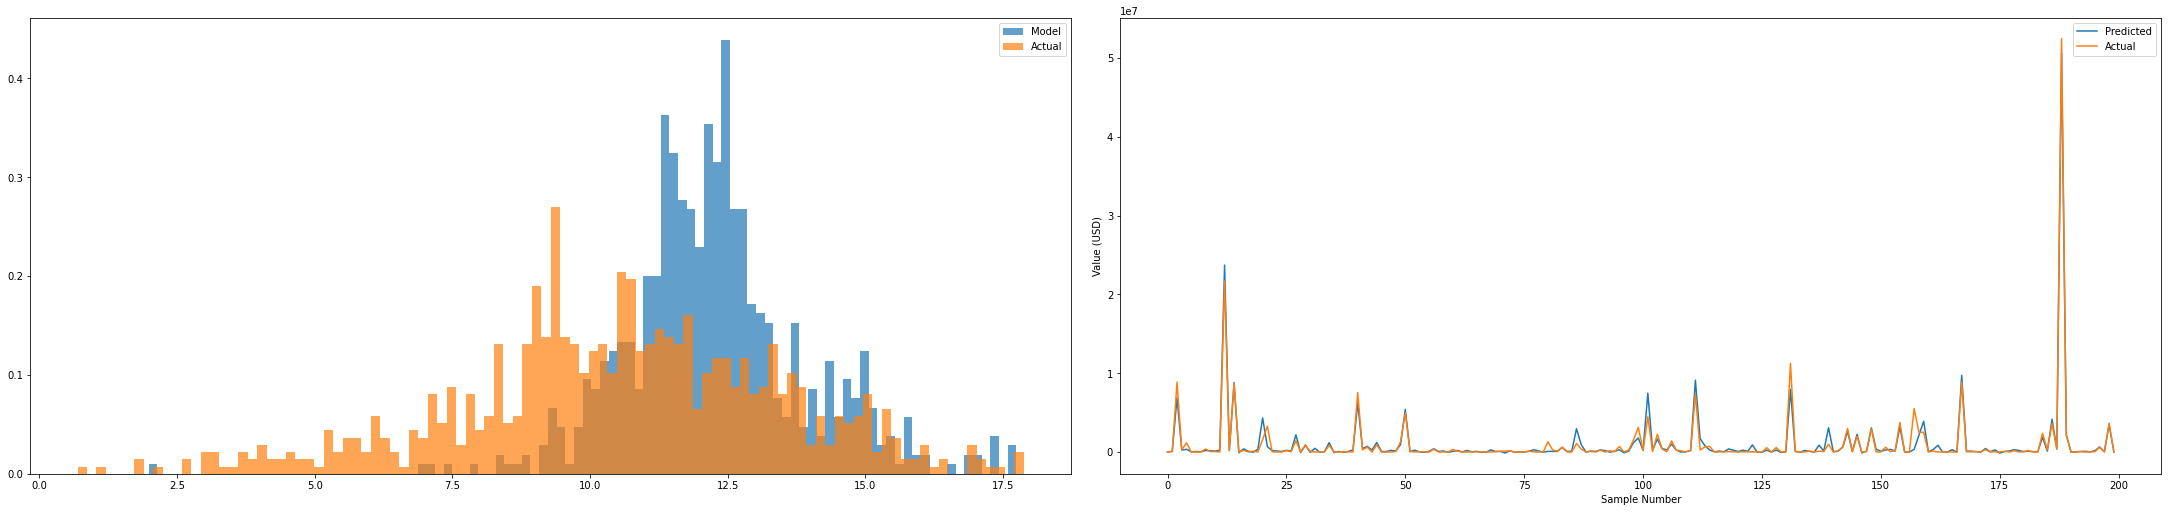

In [11]:
#test
test_df = pd.DataFrame({
    'adjusted': y_pred,
    'control': y_pred
})

fig, ax = plt.subplots(1, 2, figsize=(30, 7), constrained_layout=True)

ax[0].hist(np.log(test_df['adjusted']), density = True, alpha=0.7, label='Model',bins=100)
ax[0].hist(np.log(y_test), density = True, alpha=0.7, label='Actual', bins=100)
ax[0].legend(loc='upper right')

test_df['control'] = y_test.values

ax[1].plot(test_df[0:200])
ax[1].legend(['Predicted', 'Actual'])
ax[1].set_ylabel('Value (USD)')
ax[1].set_xlabel('Sample Number')

In [12]:
y_pred_final = model.fit(X, y).predict(final)

In [13]:
submission = pd.DataFrame({
    'Trade Value': y_pred_final
})

In [14]:
submission.loc[submission['Trade Value']<0,'Trade Value'] = 0

In [15]:
submission.to_csv('submission.csv', index=False)